# Analysis of Benchmarking Results for Partitioned LSMTree

In [1]:
import os.path
import json
from glob import glob
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns

plt.style.use(['fivethirtyeight'])
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 400)
pd.set_option('display.max_colwidth', 100)

colors = [c['color'] for c in plt.rcParams['axes.prop_cycle']]
ops = ['put', 'get', 'delete']

In [2]:
figdir = 'figures/partitioned_lsm'
!mkdir -p $figdir

# Loading Data

In [3]:
specs = pd.read_json('results/partitioned_lsm/benchmark_part_lsm_specs.jsonl', lines=True)
print(len(specs))
specs.head()

125


,spec,created_at,events,id,last_modified,status
0,"{'partitions': 16, 'seconds': 3600, 'value_length': 1024, 'key_space_size': 100000000, 'known_ke...",2020-05-02 13:08:45.687435,"[{'msg': 'starting', 'hostname': 'ec2-54-191-160-143.us-west-2.compute.amazonaws.com', 'time': '...",0dfc0d22-8c76-11ea-b1d1-00155d010301,2020-05-02T13:15:18.796641,running
1,"{'partitions': 8, 'seconds': 3600, 'value_length': 1024, 'key_space_size': 100000000, 'known_key...",2020-04-30 08:59:00.321243,"[{'msg': 'Cancelled as duplicate', 'hostname': 'master', 'time': '2020-04-30T09:35:57.903595'}]",d4712913-8ac0-11ea-b1d1-00155d010301,2020-04-30T09:35:57.903595,cancelled
2,"{'partitions': 4, 'seconds': 3600, 'value_length': 1024, 'key_space_size': 100000000, 'known_key...",2020-04-29 20:48:46.571357,"[{'msg': 'starting', 'hostname': 'ec2-35-164-210-77.us-west-2.compute.amazonaws.com', 'time': '2...",58db5279-8a7c-11ea-b1d1-00155d010301,2020-04-30T01:53:17.412197,succeeded
3,"{'partitions': 16, 'seconds': 3600, 'value_length': 1024, 'key_space_size': 100000000, 'known_ke...",2020-05-02 13:08:46.435927,"[{'msg': 'starting', 'hostname': 'ec2-54-187-66-184.us-west-2.compute.amazonaws.com', 'time': '2...",0dfc0d2b-8c76-11ea-b1d1-00155d010301,2020-05-02T13:15:11.506474,running
4,"{'partitions': 8, 'seconds': 3600, 'value_length': 1024, 'key_space_size': 100000000, 'known_key...",2020-04-30 08:59:00.805861,"[{'msg': 'Cancelled as duplicate', 'hostname': 'master', 'time': '2020-04-30T09:35:57.990984'}]",d4712919-8ac0-11ea-b1d1-00155d010301,2020-04-30T09:35:57.990984,cancelled


In [4]:
specs['status'].value_counts()

succeeded    60
cancelled    45
running      20
Name: status, dtype: int64

In [5]:
results = pd.read_json('results/partitioned_lsm/benchmark_part_lsm_results.jsonl', lines=True, convert_dates=False)
print(len(results))
results.sample(5)

26146


,delete,get_found,spec_id,delete_found,get,file_size,put,nano_time
14687,264351,71524,5985707c-8a7c-11ea-b1d1-00155d010301,264351,271820,86145362931,264552,6549853218967
16731,23950,9004,5aa705bf-8ac6-11ea-b1d1-00155d010301,23950,23801,80954526915,431433,8928046356063
18144,85667,96240,5b6b2907-8ac6-11ea-b1d1-00155d010301,85667,1459101,9356109333,172129,802197478937
8579,7371,27635,5b6b290b-8ac6-11ea-b1d1-00155d010301,7371,128075,82772608878,15059,6806460678675
25072,470613,24665,5ca56836-8ac6-11ea-b1d1-00155d010301,470613,104444,68981220790,470621,8576847963378


## Preprocess Results

In [6]:
constant_parameters = ['seconds', 'value_length', 'key_space_size', 'known_key_rate_percent', 'trial_index',
                       'pending_write_merge_threshold', 'index_rate']

In [7]:
spec_values = pd.concat([specs[['id', 'status']], pd.DataFrame(list(specs['spec']), index=specs.index)], axis=1)
spec_values['workload'] = spec_values['put_del_get']
spec_values['index_rate'] = spec_values['base_index_rate']
spec_values = spec_values.drop(['put_del_get', 'base_index_rate'], axis=1)
for param in constant_parameters:
    assert spec_values[param].nunique() == 1, f'{param} is not constant'
spec_values = spec_values.drop(constant_parameters, axis=1)
spec_values.sample(5)

,id,status,partitions,thread_count,workload
49,d471290b-8ac0-11ea-b1d1-00155d010301,cancelled,1,16,BALANCED
88,5b6b2907-8ac6-11ea-b1d1-00155d010301,succeeded,4,4,GET_HEAVY
115,d4712918-8ac0-11ea-b1d1-00155d010301,cancelled,4,8,BALANCED
7,58db5274-8a7c-11ea-b1d1-00155d010301,succeeded,8,1,BALANCED
2,58db5279-8a7c-11ea-b1d1-00155d010301,succeeded,4,8,BALANCED


In [8]:
grouped_results = []
for spec_id, spec_results in results.groupby('spec_id'):
    spec_results = spec_results.sort_values('nano_time')
    spec_results['t'] = (spec_results['nano_time'] - spec_results['nano_time'].iloc[0]) / 1e9
    grouped_results.append({
        'spec_id': spec_id,
        'results': spec_results,
        'final_file_size': spec_results['file_size'].iloc[-1],
        'sum_put': spec_results['put'].sum(),
        'sum_get': spec_results['get'].sum(),
        'sum_delete': spec_results['delete'].sum()
    })
grouped_results = pd.DataFrame(grouped_results)
grouped_results = pd.concat([spec_values.set_index('id'), grouped_results.set_index('spec_id')], axis=1)
grouped_results = grouped_results.dropna()
grouped_results = grouped_results[grouped_results['status'].isin(['succeeded', 'running'])]
grouped_results.sample(5).T

,58db5274-8a7c-11ea-b1d1-00155d010301,0dfc0d2f-8c76-11ea-b1d1-00155d010301,5aa705ba-8ac6-11ea-b1d1-00155d010301,5b6b2918-8ac6-11ea-b1d1-00155d010301,5b6b2909-8ac6-11ea-b1d1-00155d010301
status,succeeded,running,succeeded,succeeded,succeeded
partitions,8,16,4,1,1
thread_count,1,4,4,8,8
workload,BALANCED,PUT_HEAVY,PUT_HEAVY,DELETE_HEAVY,GET_HEAVY
results,delete get_found spec_id delete_found get file_si...,delete get_found spec_id delete_found get file_siz...,delete get_found spec_id delete_found get file_siz...,delete get_found spec_id delete_found get file_s...,delete get_found spec_id delete_found get file_siz...
final_file_size,6.21731e+10,9.91567e+10,1.06787e+11,1.05929e+11,5.82109e+10
sum_put,7.78147e+07,1.53321e+08,1.68656e+08,1.33837e+08,3.73351e+07
sum_get,8.01753e+07,8.5156e+06,9.36948e+06,2.97358e+07,3.17251e+08
sum_delete,7.78035e+07,8.51553e+06,9.37124e+06,1.33846e+08,1.86645e+07


In [9]:
grouped_results['status'].value_counts()

succeeded    60
running      20
Name: status, dtype: int64

In [10]:
normed_results = grouped_results.copy()
normed_results['duration_seconds'] = normed_results['results'].map(lambda r: r['t'].max())
for op in ops:
    normed_results[op] = normed_results['sum_' + op] / normed_results['duration_seconds'] / 1000
normed_results = normed_results.drop(['results'] + ['sum_' + op for op in ops], axis=1)
normed_results['sum'] = normed_results[ops].sum(axis=1)
normed_results['final_file_size'] /= 1e9
normed_results = normed_results.set_index(['workload', 'partitions', 'thread_count'])
normed_results.sample(5)

,,,status,final_file_size,duration_seconds,put,get,delete,sum
workload,partitions,thread_count,,,,,,,
BALANCED,16,16,running,51.548188,1400.746823,73.665270,75.899917,73.662921,223.228107
DELETE_HEAVY,4,32,succeeded,109.188842,3591.343556,52.371170,11.638411,52.371156,116.380737
GET_HEAVY,4,4,succeeded,56.510684,3590.509995,14.452238,122.831384,7.225513,144.509135
DELETE_HEAVY,16,32,running,82.852267,1411.435193,102.631730,22.801094,102.616216,228.049040
PUT_HEAVY,4,32,succeeded,174.374491,3592.219930,87.683225,4.870942,4.870806,97.424973


status  final_file_size  duration_seconds         put         get      delete         sum
workload     partitions thread_count                                                                                            
GET_HEAVY    16         8             running        33.493381       1420.831243   29.872330  253.942212   14.937587  298.752130
                        16            running        33.168839       1410.709039   29.825811  253.510215   14.912600  298.248626
                        32            running        40.681719       1430.518813   29.193622  248.170510   14.596070  291.960202
                        4             running        24.286952       1420.431228   27.013889  229.732242   13.507518  270.253649
DELETE_HEAVY 16         32            running        82.852267       1411.435193  102.631730   22.801094  102.616216  228.049040

status  final_file_size  duration_seconds        put        get     delete        sum
workload     partitions thread_count                                                                                          
DELETE_HEAVY 1          1             succeeded        61.966049       3590.750490  22.904952   5.086769  22.901032  50.892753
BALANCED     1          1             succeeded        38.780916       3590.603005  14.655966  15.099651  14.655085  44.410702
GET_HEAVY    1          1             succeeded        14.282154       3590.532457   4.401002  37.414930   2.201009  44.016942
PUT_HEAVY    4          1             succeeded        84.239681       3591.626139  38.720332   2.151660   2.150574  43.022566
             1          1             succeeded        74.939091       3591.010080  33.251394   1.847321   1.848149  36.946864

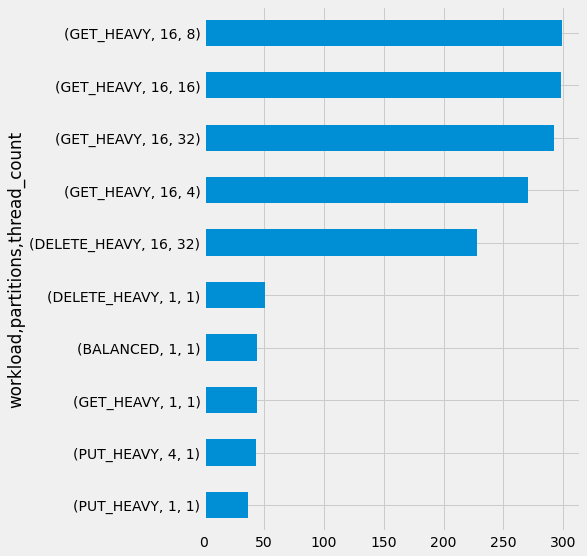

In [11]:
x = normed_results.sort_values('sum', ascending=False)
display(x.head())
display(x.tail())
pd.concat([x['sum'].head(), x['sum'].tail()]).iloc[::-1].plot.barh(figsize=(6,9))

# Analaysis

In [12]:
workload_to_color = {
    'BALANCED': '#008fd5',
    'DELETE_HEAVY': '#fc4f30',
    'PUT_HEAVY': '#e5ae38',
    'GET_HEAVY': '#6d904f'
}
thread_to_color = dict(zip(sorted(set(spec_values['thread_count'])), colors))
partition_to_ls = dict(zip(sorted(set(spec_values['partitions'])), ['-', '--', ':']))
partition_to_marker = dict(zip(sorted(set(spec_values['partitions'])), ['o', 's', '^']))

In [13]:
ax.text?

Object `ax.text` not found.


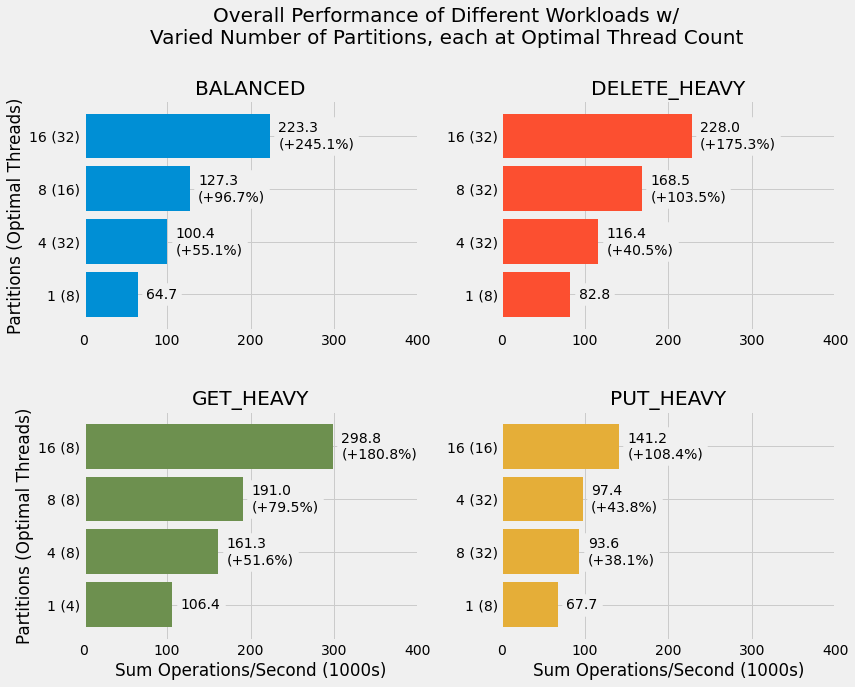

In [20]:
def select_highest_performing_thread_count(df):
    s = df.set_index('thread_count')['sum']
    i = s.idxmax()
    return pd.Series({'thread_count': i, 'sum': s[i]})

def add_bar_values(x, sep='\n'):
    for i, v in enumerate(x):
        ax.text(v + 10, i, f'{v:.1f}' + 
                ('' if i==0 else f'{sep}(+{100 * (v - x.iloc[0]) / x.iloc[0]:.1f}%)'), 
                verticalalignment='center',
                bbox=dict(facecolor='#f0f0f0', alpha=1))

fig = plt.figure(figsize=(12, 10))
for ax_i, (workload, workload_df) in enumerate( normed_results.groupby('workload')):
    ax = fig.add_subplot(2, 2, 1+ax_i)
    ax.set_title(workload)
    
    workload_df = workload_df.reset_index().groupby('partitions').apply(select_highest_performing_thread_count)
    x = workload_df.reset_index().set_index(['partitions', 'thread_count'])['sum'].sort_values(ascending=True)
    x.plot.barh(ax=ax, color=workload_to_color[workload], width=0.85)
    add_bar_values(x)
    
    ax.set_yticklabels([f'{int(p)} ({int(t)})' for p,t in x.index])
    
    plt.xlim(0, 400)
    if ax_i>=2:
        ax.set_xlabel('Sum Operations/Second (1000s)')
    if ax_i%2==0:
        ax.set_ylabel('Partitions (Optimal Threads)')
    else:
        ax.set_ylabel('')
fig.subplots_adjust(hspace=0.35, top=0.82, wspace=0.25)
fig.suptitle('Overall Performance of Different Workloads w/\n'
             'Varied Number of Partitions, each at Optimal Thread Count', 
             y=0.95, size=20)
plt.savefig(figdir + '/overall_performance.png', bbox_inches='tight')

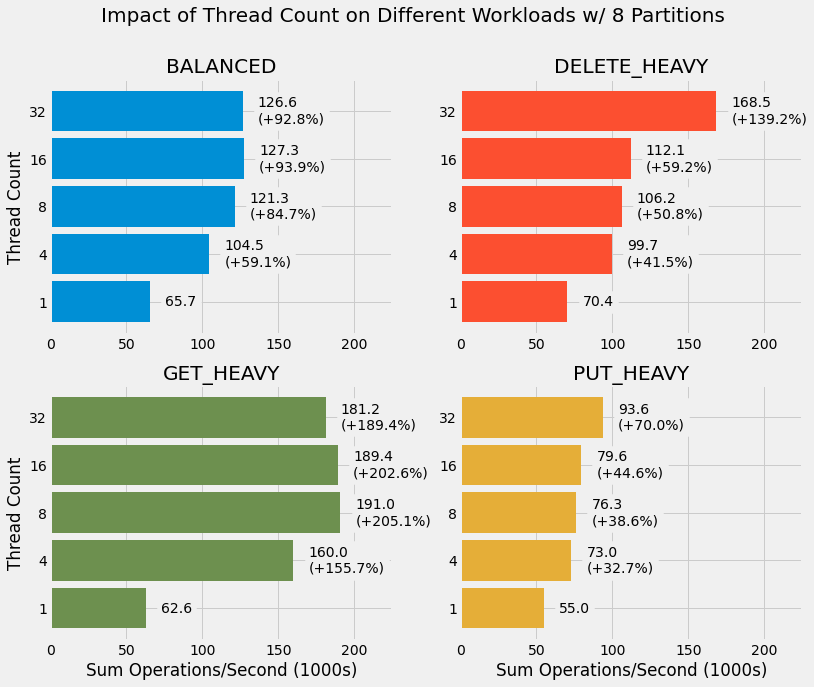

In [15]:
fig = plt.figure(figsize=(12, 10))
x = normed_results.reset_index()
x = x[x['partitions'] == 8]
for ax_i, (workload, workload_df) in enumerate(x.groupby('workload')):
    ax = fig.add_subplot(2, 2, 1+ax_i)
    ax.set_title(workload)
    
    x = workload_df.set_index('thread_count')['sum'].sort_index()
    x.plot.barh(ax=ax, color=workload_to_color[workload], width=0.85)
    add_bar_values(x)
    
    plt.xlim(0, 225)
    if ax_i>=2:
        ax.set_xlabel('Sum Operations/Second (1000s)')
    if ax_i%2==0:
        ax.set_ylabel('Thread Count')
    else:
        ax.set_ylabel('')
fig.subplots_adjust(hspace=0.2, top=0.85)
fig.suptitle('Impact of Thread Count on Different Workloads w/ 8 Partitions', 
             y=0.95, size=20)
plt.savefig(figdir + '/thread_impact_8partitions.png', bbox_inches='tight')

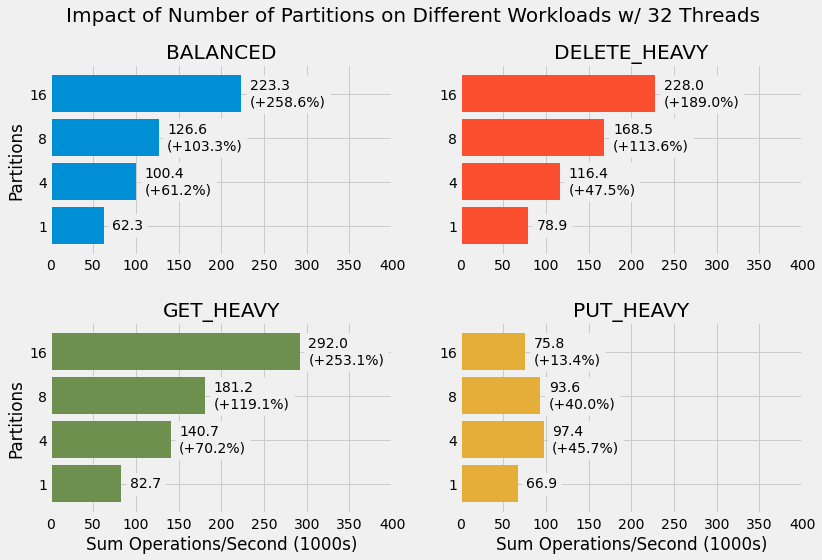

In [21]:
fig = plt.figure(figsize=(12, 8))
x = normed_results.reset_index()
x = x[x['thread_count'] == 32]
for ax_i, (workload, workload_df) in enumerate(x.groupby('workload')):
    ax = fig.add_subplot(2, 2, 1+ax_i)
    ax.set_title(workload)
    
    x = workload_df.set_index('partitions')['sum'].sort_index()
    x.plot.barh(ax=ax, color=workload_to_color[workload], width=0.85)
    add_bar_values(x)
    
    plt.xlim(0, 400)
    if ax_i>=2:
        ax.set_xlabel('Sum Operations/Second (1000s)')
    if ax_i%2==0:
        ax.set_ylabel('Partitions')
    else:
        ax.set_ylabel('')
fig.subplots_adjust(hspace=0.35, top=0.85)
fig.suptitle('Impact of Number of Partitions on Different Workloads w/ 32 Threads', 
             y=0.95, size=20)
plt.savefig(figdir + '/partitions_impact_32threads.png', bbox_inches='tight')

Text(0.5, 0.95, 'Overall Performance of Different Workloads w/ Varied Number of Partitions and Thread Count')

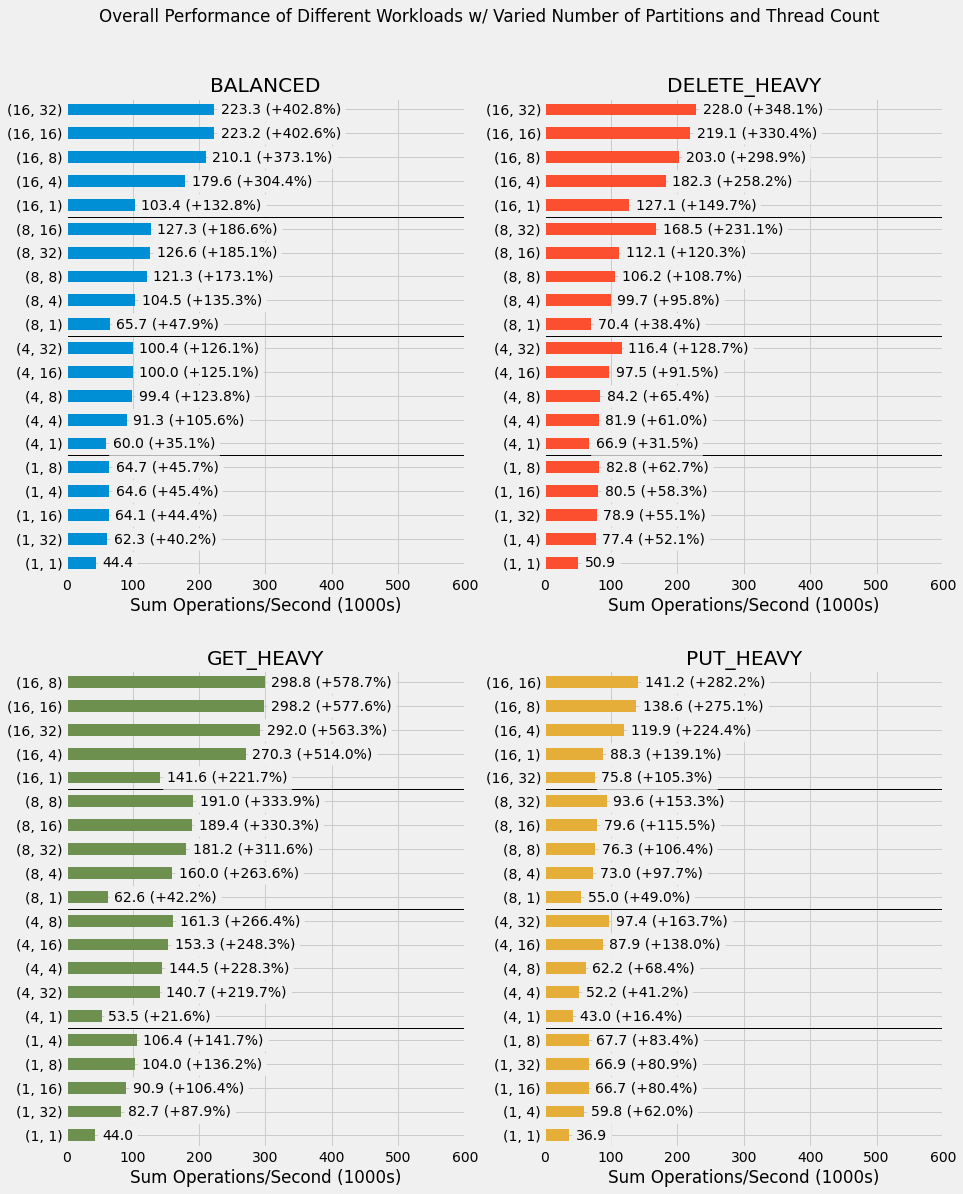

In [17]:
fig = plt.figure(figsize=(14, 18))
for i, (color, (workload, workload_df)) in enumerate(zip(colors, normed_results.groupby('workload'))):
    color = workload_to_color[workload]
    ax = fig.add_subplot(2, 2, i+1)
    ax.set_title(workload)
    workload_df = workload_df.reset_index().sort_values(['partitions', 'sum']).set_index(['partitions', 'thread_count'])
    x = workload_df['sum']
    x.plot.barh(ax=ax, color=color)
    add_bar_values(x, sep=' ')
    last_p = None
    for i, (p, _) in enumerate(x.index):
        if last_p is not None and last_p != p:
            ax.axhline(i-0.5, color='k', ls='-', lw=1)
        last_p = p
    plt.xlim(0, 600)
    if i>=2:
        ax.set_xlabel('Sum Operations/Second (1000s)')
    if i%2==0:
        ax.set_ylabel('Partitions, Thread Count')
    else:
        ax.set_ylabel('')
fig.suptitle('Overall Performance of Different Workloads w/ Varied Number of Partitions and Thread Count', y=0.95)

KeyError: 16

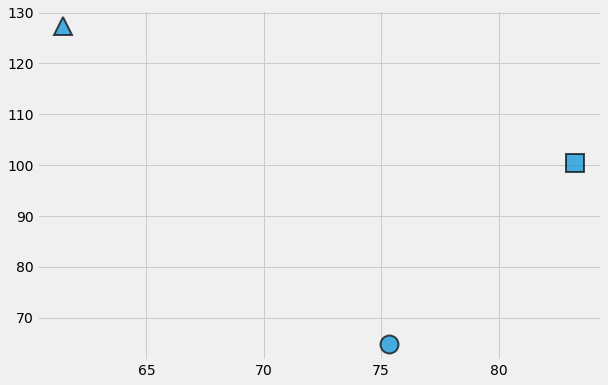

In [18]:

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(1, 1, 1)
for workload, workload_df in normed_results.groupby('workload'):
    color = workload_to_color[workload]
    for partition, partition_df in workload_df.reset_index().groupby('partitions'):
        row = partition_df.loc[partition_df['sum'].idxmax()]
        ax.plot([row['final_file_size']], [row['sum']],
                 color=color, marker=partition_to_marker[partition],
                 ms=18, mew=2, mec='k', alpha=0.7)
    ax.plot([-1], [-1], color=color, ls='None', ms=18, mew=2, mec='k', marker='s', label=f'{workload}')
    

for partition, marker in partition_to_marker.items():
    ax.plot([-1], [-1], marker=marker, color='k', ls='None', ms=18, label=f'{partition} Partitions')


ax.set_xlabel('Final Total Files Size (GB)')
ax.set_ylabel('Sum Operations/Second (1000s)')
ax.legend(loc='upper right', frameon=True, framealpha=1, edgecolor='k', borderpad=1)
ax.set_xlim(25, 200)
ax.set_ylim(50, 200)
ax.set_title('Relation Between File Size and Performance w/ Different Workloads and'
             '\nVaried Number of Partitions, each at Optimal Thread Count', y=1.1)
plt.savefig(figdir + '/performance_file_size_relation.png', bbox_inches='tight')

# Time Dependent Analysis

In [ ]:
import matplotlib.patches as patches

def diff(x):
    return x.iloc[1::].reset_index(drop=True) - x.iloc[:-1:].reset_index(drop=True)


r = grouped_results
r = r[r['workload'] == 'BALANCED']
r = r[r['partitions'] == 8]
r = r[r['thread_count'] == 16]
assert len(r) == 1
r = r.iloc[0]
x = r['results']
x = x.copy()

t = x['t'] / 60
ops_sec = (x[['put', 'get', 'delete']].sum(axis=1).iloc[1::].reset_index(drop=True) /
            diff(x['t']))
ops_sec /= 1000

def plot_ops_size(index):
    ax1 = fig.add_subplot(2, 1, index)
    ax2 = ax1.twinx()

    l1, = ax1.plot(t[1::], ops_sec, color=colors[0], label='Sum Ops/Sec', marker='o', lw=1, ls=':')
    l2, = ax2.plot(t, x['file_size'] / 1e9, color=colors[1], label='File Size', marker='^', lw=1, ls='--')

    ax1.grid(False, axis='y')
    ax2.grid(False, axis='y')
    ax1.legend([l1, l2], [l1.get_label(), l2.get_label()],
               loc='upper center', ncol=2, framealpha=1)
    ax1.set_ylabel('Sum Operations/Sec (Thousands)', color=colors[0])
    ax1.tick_params(axis='y', colors=colors[0])
    ax2.set_ylabel('Total File Size (GB)', color=colors[1])
    ax2.tick_params(axis='y', colors=colors[1])
    ax1.set_xlabel('Trial Time (minutes)')
    return ax1, ax2

with plt.rc_context({'axes.edgecolor':'k', 'axes.linewidth':1}):
    fig = plt.figure(figsize=(8,11))
    fig.subplots_adjust(hspace=0.25)

    ax1f, ax2f = plot_ops_size(1)
    rect = patches.Rectangle((9,0),12,500, linewidth=1, edgecolor='k', facecolor='none', ls='--')
    ax1f.add_patch(rect)
    ax1f.set_title('Full Scenario Run')

    ax1z, ax2z = plot_ops_size(2)
    ax1z.set_title('Zoomed In')


    for a,b in [[(9,0), (9, 500)], [(21,0), (21, 500)]]:
        conn = patches.Cocon = patches.ConnectionPatch(xyA=a, xyB=b, coordsA="data", coordsB="data",
                                                       axesA=ax1f, axesB=ax1z, color='k', lw=1, ls='--')
        ax1f.add_artist(conn)

    ax1z.set_xlim(9, 21)
    ax1z.set_ylim(0, 500)
    ax2z.set_ylim(0, 100)

    fig.suptitle('Performance and File Size over time for\n' +
                 f'{r["workload"]} workload w/ {r["partitions"]} partitions and {r["thread_count"]} threads'
                 ,y=0.98, size=20)
    plt.savefig(figdir + '/time_dependent_balanced_8partitions_16_threads.png', bbox_inches='tight')


In [ ]:


fig = plt.figure(figsize=(9, 17))
for i, (workload, workload_df) in enumerate(grouped_results.groupby('workload')):
    ax = fig.add_subplot(4, 1, i+1)
    #print(workload, len(workload_df))
    
    for spec_id, spec_row in workload_df.sort_values(['partitions', 'thread_count']).iterrows():
        #print(workload, f"{spec_row['partitions']}, {spec_row['thread_count']}")
        row_results = spec_row['results']
        t = row_results['t'] / 60
        ops_sec = (row_results[['put', 'get', 'delete']].sum(axis=1).iloc[1::].reset_index(drop=True) /
                   diff(row_results['t']))
        ops_sec /= 1000
        ax.plot(t.iloc[1::], ops_sec,
                label=f"{spec_row['partitions']}, {spec_row['thread_count']}",
                color=thread_to_color[spec_row['thread_count']],
                ls=partition_to_ls[spec_row['partitions']])
    ax.legend(loc='upper right', ncol=4)
    ax.set_title(workload)
    plt.ylim(0, 500)
    plt.xlim(0, 60)
#plt.xlim(0, 5)

In [ ]:
fig = plt.figure(figsize=(9, 17))
for i, (workload, workload_df) in enumerate(grouped_results.groupby('workload')):
    ax = fig.add_subplot(4, 1, i+1)    
    for spec_id, spec_row in workload_df.sort_values(['partitions', 'thread_count']).iterrows():
        row_results = spec_row['results']
        ax.plot(row_results['t'] / 60, row_results['file_size'] / 1e9,
                label=f"{spec_row['partitions']}, {spec_row['thread_count']}",
                color=thread_to_color[spec_row['thread_count']],
                ls=partition_to_ls[spec_row['partitions']])
    ax.legend(loc='upper right', ncol=4)
    ax.set_title(workload)
    plt.ylim(0, 200)
    plt.xlim(0, 60)
